In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Case study of circuits in same functional but different evolutionary regimes

## Imports

In [8]:

from functools import partial
from typing import Optional, Tuple
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'gpu')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.70" 

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.misc.helper import vanilla_return
from synbio_morpher.utils.misc.numerical import add_recursively
from synbio_morpher.utils.misc.type_handling import append_nest_dicts
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import generate_analytics
from synbio_morpher.utils.common.testing.shared import CONFIG
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller

CONFIG = prepare_config(CONFIG)
root_dir = '..'

## Load data

In [9]:
fn = '../data/ensemble_mutation_effect_analysis/2023_07_17_105328/summarise_simulation/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data = data.drop(data[data['sample_name'].isna()].index)

config = load_json_as_dict(os.path.join(fn.split('summarise')[0], 'mutation_effect_on_interactions_signal', 'experiment.json'))
config = config['config_filepath']
config['experiment']['purpose'] = 'tests'


In [101]:
data['mutated_species'] = data['mutation_name'].str[:5].replace('ref_c', '')

0               
1               
2               
3          RNA_0
4          RNA_0
           ...  
1628995    RNA_2
1628996    RNA_2
1628997    RNA_2
1628998    RNA_2
1628999    RNA_2
Name: mutated_species, Length: 1629000, dtype: object

## Find 2 circuits

In [10]:
def find_similar_distant_circuits(similars: tuple, distants: tuple, weights: Optional[tuple]=None, uselog=True) -> Tuple[int]:
    def calculate_diffs(og):
        similars_diff = f(og[:, None] / og[None, :])
        return np.where(np.isnan(similars_diff) | (np.abs(similars_diff) == np.inf), 0, similars_diff)
    
    if weights is None:
        weights = np.ones(len(similars) * len(distants))
    f = np.log if uselog else vanilla_return

    similars_diffs = [calculate_diffs(similar) for similar in similars]
    distants_diffs = [calculate_diffs(distant) for distant in distants]
        
    joint_similars = np.zeros(similars_diffs[0].shape)
    for d, w in zip(similars_diffs, weights[:len(similars)]):
        joint_similars += w * np.abs(d)
    joint_similars = np.where(joint_similars != 0, joint_similars.max() - np.abs(joint_similars), 0)
        
    joint_distants = np.zeros(distants_diffs[0].shape)
    for d, w in zip(distants_diffs, weights[len(similars):]):
        joint_distants += w * np.abs(d)

    joint = joint_similars + joint_distants

    circ1, circ2 = np.where(joint == np.abs(joint).max()) 
    circ1, circ2 = np.array(list(set([tuple(sorted([c1, c2])) for c1, c2 in zip(circ1, circ2)]))).T
    
    return circ1, circ2


From [Automated Design of Synthetic Gene Circuits in the Presence of Molecular Noise](https://pubs.acs.org/doi/full/10.1021/acssynbio.3c00033)

In [11]:
data['adaptability'] = np.power(data['sensitivity_wrt_species-6'], -2) + 100 * np.power(data['precision_wrt_species-6'], -2) + 0.01 * np.power(data['fold_change'], -2)


In [12]:
analytics = [c for c in get_true_names_analytics(data) if ('sensitivity' in c) or ('precision' in c) or ('overshoot' in c)] + ['adaptability']
agg1_stds_muts = data.groupby(['circuit_name', 'sample_name'], as_index=False).agg({c: lambda x: np.std(np.log10(x)) if (sum(x) != 0.0) and (sum(x) != np.inf) else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean_muts = data.groupby(['circuit_name', 'sample_name'], as_index=False).agg({c: lambda x: np.mean(np.log10(x)) if (sum(x) != 0.0) and (sum(x) != np.inf) else 0.0 for c in analytics + ['num_interacting', 'num_self_interacting']})
agg1_mean_init = data[data['mutation_num'] == 0].reset_index()

/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
species_selected = 'RNA_2'

### Display selected circuits

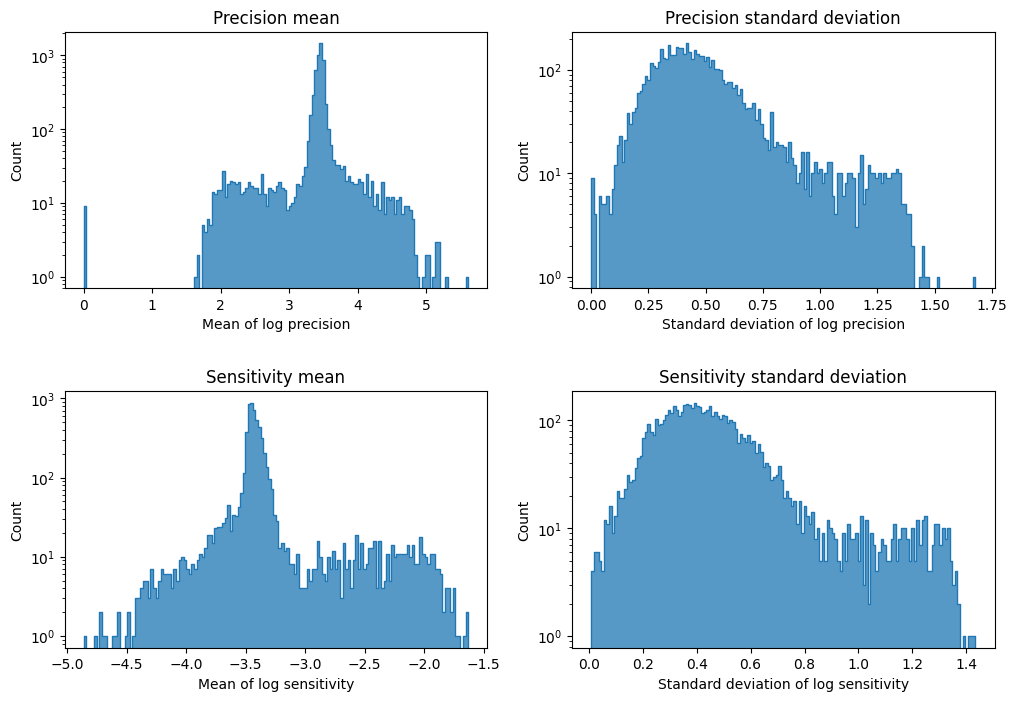

In [14]:
fig = plt.figure(figsize=(6*2, 2*4))
fig.subplots_adjust(hspace=0.4)

ax = plt.subplot(2,2,1)
sns.histplot(agg1_mean_muts[agg1_mean_muts['sample_name'] != 'RNA_0'], x='precision_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Precision mean')
plt.xlabel('Mean of log precision')

ax = plt.subplot(2,2,2)
sns.histplot(agg1_stds_muts[agg1_stds_muts['sample_name'] != 'RNA_0'], x='precision_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Precision standard deviation')
plt.xlabel('Standard deviation of log precision')

ax = plt.subplot(2,2,3)
sns.histplot(agg1_mean_muts[agg1_mean_muts['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Sensitivity mean')
plt.xlabel('Mean of log sensitivity')

ax = plt.subplot(2,2,4)
sns.histplot(agg1_stds_muts[agg1_stds_muts['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', element='step', bins=150, log_scale=[False, True])
plt.title('Sensitivity standard deviation')
plt.xlabel('Standard deviation of log sensitivity')

plt.savefig('ok5.svg')


In [15]:
agg1_mean_init

,level_0,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,name,interacting,...,steady_states_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name,adaptability
0,0,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_0,[[0 1]],...,0.0,1.0,1.0,1.0,1.0,1.0,inf,1.0,RNA_0,8.966680e+01
1,1,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_0,[[0 1]],...,0.0,1.0,1.0,1.0,1.0,1.0,inf,1.0,RNA_1,2.089958e+02
2,2,toy_mRNA_circuit_0,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_0,[[0 1]],...,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_2,1.118278e+07
3,543,toy_mRNA_circuit_10,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_10,[],...,0.0,1.0,1.0,1.0,1.0,1.0,inf,1.0,RNA_0,1.004703e+02
4,544,toy_mRNA_circuit_10,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_10,[],...,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_1,9.603751e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,1627915,toy_mRNA_circuit_12698,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_12698,[],...,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_1,9.007877e+06
8996,1627916,toy_mRNA_circuit_12698,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_12698,[],...,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_2,9.007877e+06
8997,1628457,toy_mRNA_circuit_12699,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_12699,[],...,0.0,1.0,1.0,1.0,1.0,1.0,inf,1.0,RNA_0,1.004687e+02
8998,1628458,toy_mRNA_circuit_12699,ref_circuit,0,[],[],data/ensemble_mutation_effect_analysis/2023_07...,0.0,toy_mRNA_circuit_12699,[],...,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_1,9.007877e+06


### Select circuits

In [16]:
filts = (agg1_mean_init['sample_name'] == species_selected) & (
        agg1_mean_init['precision_wrt_species-6'] != np.inf) & (
            (agg1_mean_init['num_interacting'] > 0) | (agg1_mean_init['num_self_interacting'] > 0))
# & (agg1_mean_muts['precision_wrt_species-6'] != np.inf)
# filts = (agg1_mean_muts['sample_name'] == 'RNA_2') & (agg1_mean_muts['precision_wrt_species-6'] != np.inf) & (
#     agg1_mean_muts['precision_wrt_species-6'] > 2) & ((agg1_mean_muts['num_interacting'] > 1) | (agg1_mean_muts['num_self_interacting'] > 1))

circ1, circ2 = find_similar_distant_circuits(
    similars=[agg1_mean_init[filts][s].to_numpy() 
            #   for s in ['adaptability']],
              for s in ['precision_wrt_species-6', 'sensitivity_wrt_species-6']],
    distants=[agg1_stds_muts[filts][s].to_numpy() for s in ['adaptability']],
    # distants=[agg1_mean_muts[filts][s].to_numpy() for s in ['precision_wrt_species-6_ratio_from_mutation_to_base']],
    # weights=(1, 10, 0.15),
    weights=(1, 10, 0.2),
    # weights=(1, 1),
    uselog=False)


circ1_m_df = agg1_mean_muts[filts].iloc[circ1]
circ2_m_df = agg1_mean_muts[filts].iloc[circ2]
circ1_s_df = agg1_stds_muts[filts].iloc[circ1]
circ2_s_df = agg1_stds_muts[filts].iloc[circ2]

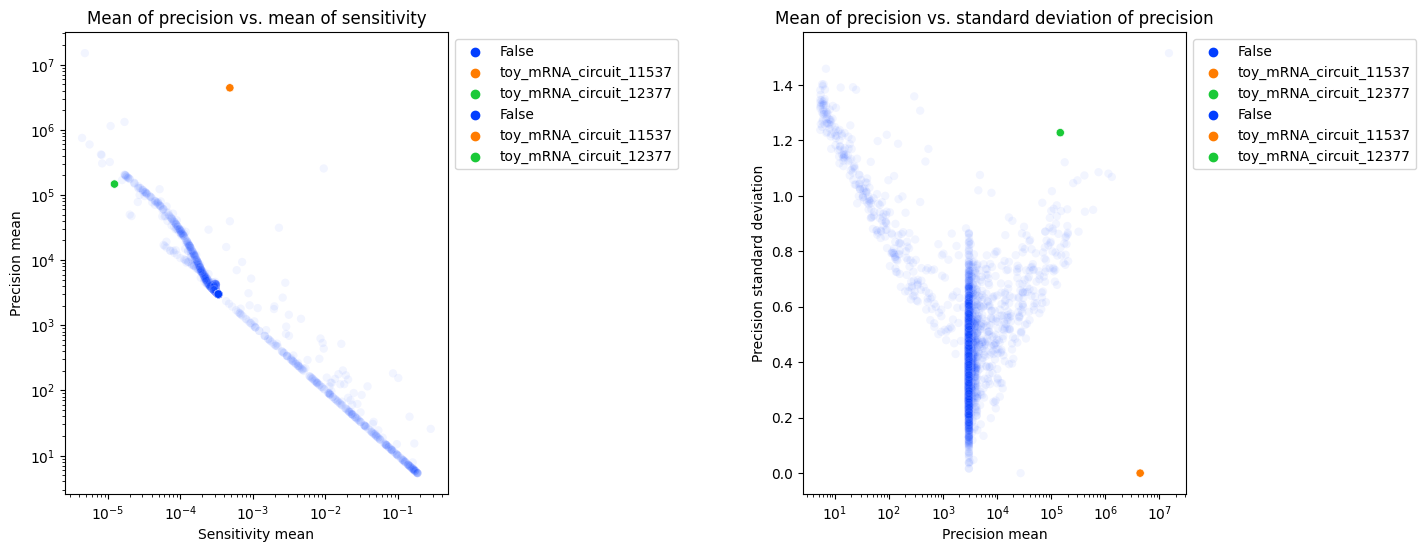

In [17]:
filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == species_selected)
hue = list(map(lambda i, c: c if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean_muts[filt].index), list(agg1_mean_muts[filt]['circuit_name'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(8*3, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,3,1)
sns.scatterplot(agg1_mean_init[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(agg1_mean_init[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=alpha,
                hue=hue,
                palette="bright",
                )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sensitivity mean')
plt.ylabel('Precision mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ax = plt.subplot(1,3,2)
sns.scatterplot(x=agg1_mean_init[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_init[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision standard deviation')
plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation of precision')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.savefig('ok4.svg')



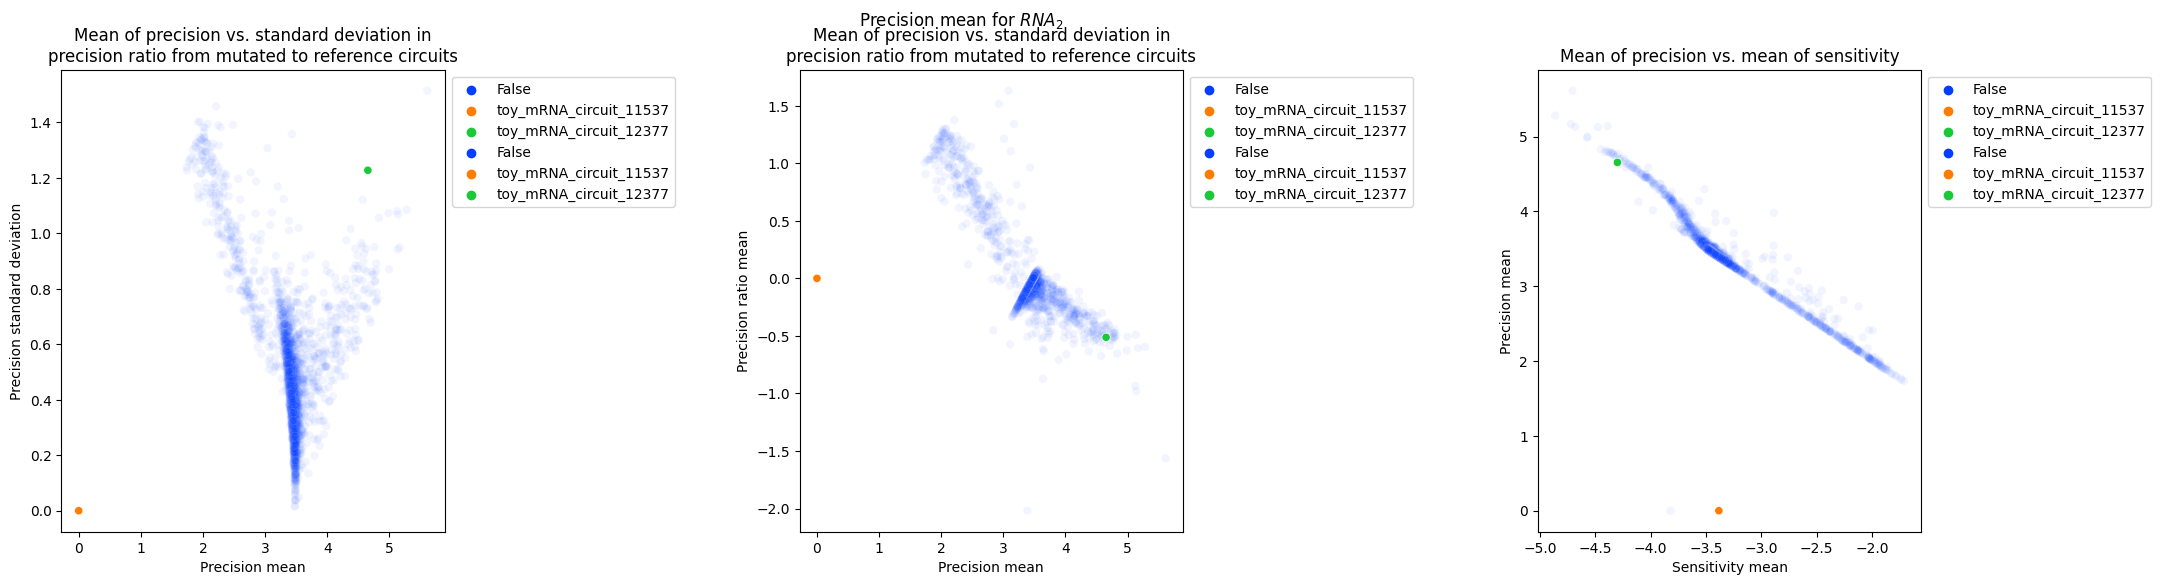

In [18]:
filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == species_selected)
hue = list(map(lambda i, c: c if (i == circ1_m_df.index[0]) or (i == circ2_m_df.index[0]) else False, 
               list(agg1_mean_muts[filt].index), list(agg1_mean_muts[filt]['circuit_name'].values)))
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

fig = plt.figure(figsize=(8*3, 6))
fig.subplots_adjust(wspace=0.925)

ax = plt.subplot(1,3,1)
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_stds_muts[filt]['precision_wrt_species-6'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision standard deviation')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ax = plt.subplot(1,3,2)
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_mean_muts[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=0.05,
                hue=hue,
                palette='bright')
sns.scatterplot(x=agg1_mean_muts[filt]['precision_wrt_species-6'], y=agg1_mean_muts[filt]['precision_wrt_species-6_ratio_from_mutation_to_base'], 
                alpha=alpha,
                hue=hue,
                palette='bright')
plt.xlabel('Precision mean')
plt.ylabel('Precision ratio mean')
# plt.xscale('log')
# plt.yscale('log')
plt.title('Mean of precision vs. standard deviation in\nprecision ratio from mutated to reference circuits')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

filt = (agg1_mean_muts['precision_wrt_species-6'] < np.inf) & (agg1_mean_muts['sensitivity_wrt_species-6'] < np.inf) & (agg1_mean_muts['sample_name'] == 'RNA_2')
alpha = list(map(lambda x: 1 if x != False else 0.0005, hue))

ax = plt.subplot(1,3,3)
sns.scatterplot(agg1_mean_muts[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=0.05,
                hue=hue,
                palette="bright")
sns.scatterplot(agg1_mean_muts[filt],
                x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                alpha=alpha,
                hue=hue,
                palette="bright",
                )
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Sensitivity mean')
plt.ylabel('Precision mean')
plt.title('Mean of precision vs. mean of sensitivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

plt.suptitle('Precision mean for $RNA_2$')

plt.savefig('ok3.svg')


## Show their evolution

In [121]:
filt1 = (data['circuit_name'] == circ1_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
filt2 = (data['circuit_name'] == circ2_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)

print(data[filt1][['circuit_name'] + get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[0])
print(data[filt2][['circuit_name'] + get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[0])

circuit_name    toy_mRNA_circuit_11537
energies_0-0                       0.0
energies_0-1                      -4.8
energies_0-2                       0.0
energies_1-1                     -1.95
energies_1-2                     -6.64
energies_2-2                    -14.22
Name: 928532, dtype: object
circuit_name    toy_mRNA_circuit_12377
energies_0-0                    -16.82
energies_0-1                       0.0
energies_0-2                       0.0
energies_1-1                    -14.78
energies_1-2                     -14.9
energies_2-2                     -2.76
Name: 1434608, dtype: object


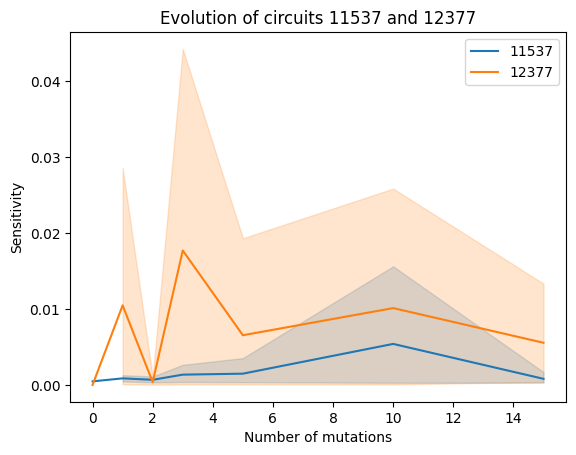

In [19]:
# sns.lineplot(data[filt1], x='mutation_num', y=np.log10(data[filt1]['sensitivity_wrt_species-6']))
sns.lineplot(data[filt1], x='mutation_num', y='sensitivity_wrt_species-6', label=circ1_m_df["circuit_name"].iloc[0].split("_")[-1])
# sns.lineplot(data[filt2], x='mutation_num', y=np.log10(data[filt2]['sensitivity_wrt_species-6']))
sns.lineplot(data[filt2], x='mutation_num', y='sensitivity_wrt_species-6', label=circ2_m_df["circuit_name"].iloc[0].split("_")[-1])

plt.title(f'Evolution of circuits {circ1_m_df["circuit_name"].iloc[0].split("_")[-1]} and {circ2_m_df["circuit_name"].iloc[0].split("_")[-1]}')
plt.xlabel('Number of mutations')
plt.ylabel('Sensitivity')
# plt.yscale('log')

plt.savefig('ok1.svg')

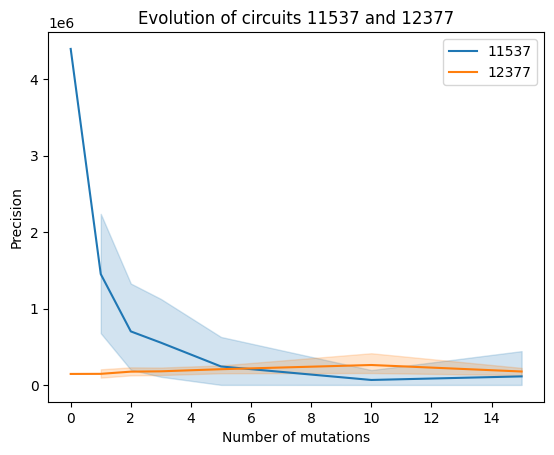

In [20]:
filt1 = (data['circuit_name'] == circ1_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
# sns.lineplot(data[filt1], x='mutation_num', y=np.log10(data[filt1]['precision_wrt_species-6']))
sns.lineplot(data[filt1], x='mutation_num', y='precision_wrt_species-6', label=circ1_m_df["circuit_name"].iloc[0].split("_")[-1])
filt2 = (data['circuit_name'] == circ2_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
# sns.lineplot(data[filt2], x='mutation_num', y=np.log10(data[filt2]['precision_wrt_species-6']))
sns.lineplot(data[filt2], x='mutation_num', y='precision_wrt_species-6', label=circ2_m_df["circuit_name"].iloc[0].split("_")[-1])

plt.title(f'Evolution of circuits {circ1_m_df["circuit_name"].iloc[0].split("_")[-1]} and {circ2_m_df["circuit_name"].iloc[0].split("_")[-1]}')
plt.xlabel('Number of mutations')
plt.ylabel('Precision')
# plt.yscale('log')

plt.savefig('ok1b.svg')

<AxesSubplot: xlabel='adaptability', ylabel='Count'>

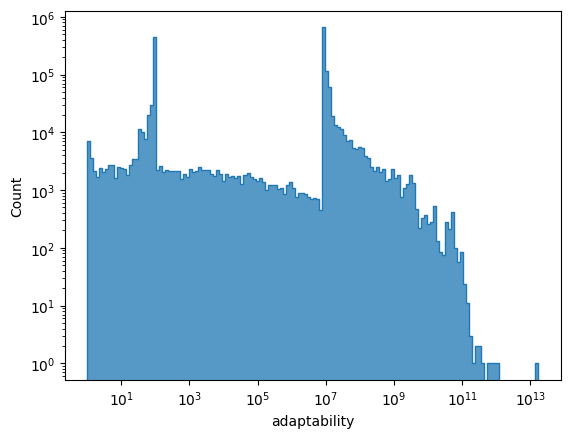

In [21]:
sns.histplot(data, x='adaptability', element='step', bins=150, log_scale=[True, True])

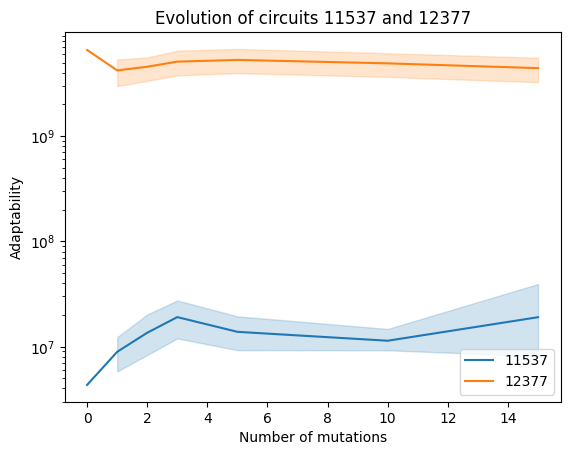

In [22]:
filt1 = (data['circuit_name'] == circ1_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
# sns.lineplot(data[filt1], x='mutation_num', y=np.log10(data[filt1]['adaptability']))
sns.lineplot(data[filt1], x='mutation_num', y='adaptability', label=circ1_m_df["circuit_name"].iloc[0].split("_")[-1])
filt2 = (data['circuit_name'] == circ2_m_df['circuit_name'].iloc[0]) & (data['sample_name'] == species_selected)
# sns.lineplot(data[filt2], x='mutation_num', y=np.log10(data[filt2]['adaptability']))
sns.lineplot(data[filt2], x='mutation_num', y='adaptability', label=circ2_m_df["circuit_name"].iloc[0].split("_")[-1])

plt.title(f'Evolution of circuits {circ1_m_df["circuit_name"].iloc[0].split("_")[-1]} and {circ2_m_df["circuit_name"].iloc[0].split("_")[-1]}')
plt.xlabel('Number of mutations')
plt.ylabel('Adaptability')
plt.yscale('log')

plt.savefig('ok1b.svg')

### Motifs

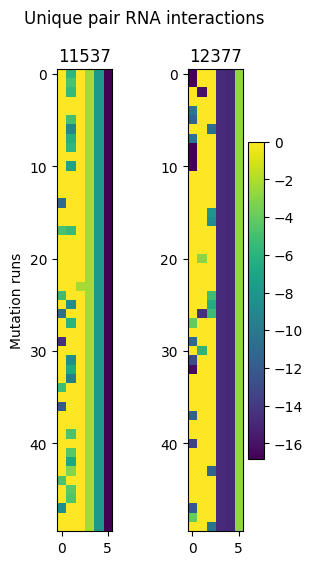

In [23]:
fig = plt.figure(figsize=(3, 6))


ax = plt.subplot(1,2,1)
plt.imshow(data[filt1][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:50].to_numpy())
plt.ylabel('Mutation runs')
plt.title(circ1_m_df['circuit_name'].iloc[0].split('_')[-1])

ax = plt.subplot(1,2,2)
plt.imshow(data[filt2][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:50].to_numpy())
plt.title(circ2_m_df['circuit_name'].iloc[0].split('_')[-1])
plt.colorbar()

plt.suptitle('Unique pair RNA interactions')

plt.savefig('ok2.svg')


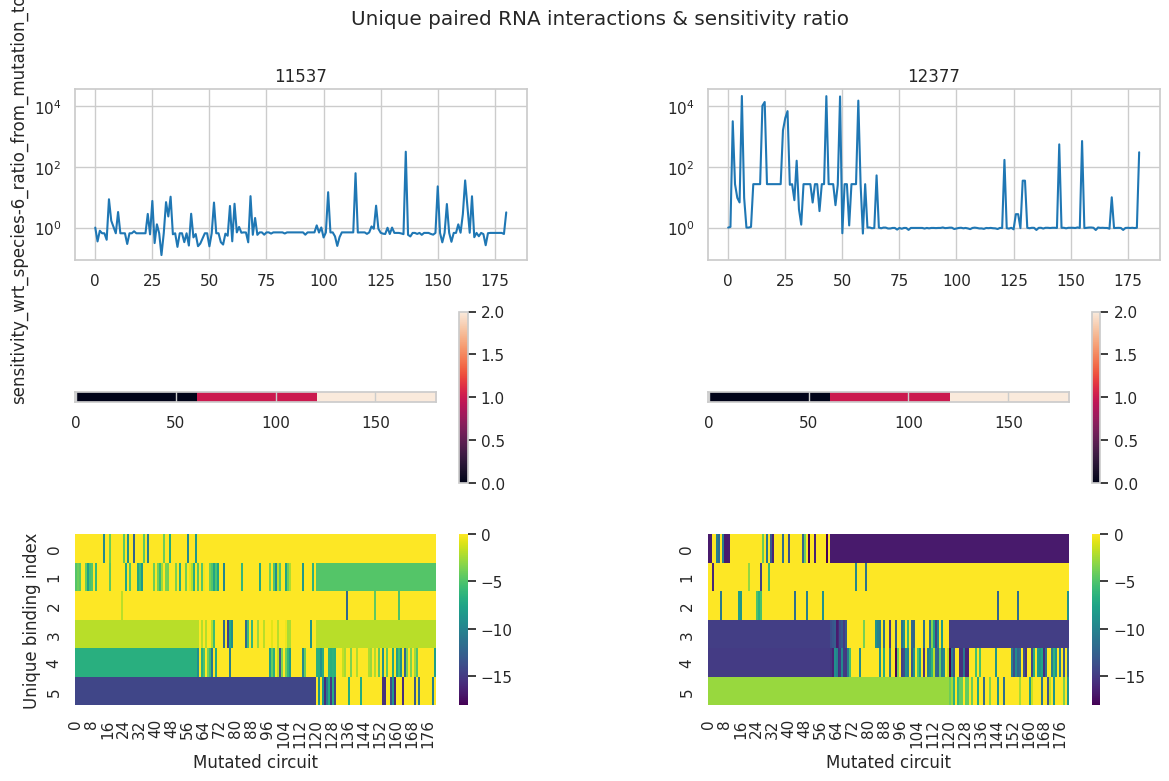

In [122]:
sns.set_context('notebook')
fig = plt.figure(figsize=(14, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

n = 181

ax1 = plt.subplot(3,2,1)
sns.lineplot(data[filt1].iloc[:n],
             y='sensitivity_wrt_species-6_ratio_from_mutation_to_base',
            #  y='sensitivity_wrt_species-6',
             x=np.arange(n))
plt.yscale('log')
plt.title(circ1_m_df['circuit_name'].iloc[0].split('_')[-1])


ax2 = plt.subplot(3,2,2)
sns.lineplot(data[filt2].iloc[:n],
             y='sensitivity_wrt_species-6_ratio_from_mutation_to_base',
            #  y='sensitivity_wrt_species-6',
             x=np.arange(n))
plt.ylabel('')
plt.yscale('log')
plt.title(circ2_m_df['circuit_name'].iloc[0].split('_')[-1])

ax1.set_ylim((np.min([ax1.get_ylim()[0], ax2.get_ylim()[0]]),
             np.max([ax1.get_ylim()[1], ax2.get_ylim()[1]])))
ax2.set_ylim((np.min([ax1.get_ylim()[0], ax2.get_ylim()[0]]),
             np.max([ax1.get_ylim()[1], ax2.get_ylim()[1]])))


vmin = np.min([data[filt1][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].min(),
              data[filt2][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].min()])
vmax = np.max([data[filt1][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].max(),
              data[filt2][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].max()])
ax3 = plt.subplot(3,2,5)
sns.heatmap(data[filt1][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].to_numpy().T, 
    cmap='viridis', vmin=vmin, vmax=vmax)
plt.xlabel('Mutated circuit')
plt.ylabel('Unique binding index')

ax4 = plt.subplot(3,2,6)
sns.heatmap(data[filt2][get_true_interaction_cols(data, 'energies', remove_symmetrical=True)].iloc[:n].to_numpy().T, 
    cmap='viridis', vmin=vmin, vmax=vmax)
plt.xlabel('Mutated circuit')
# plt.colorbar()


ax = plt.subplot(3,2,3)
plt.imshow(data[filt1]['mutated_species'].map({s: i for s, i in zip(data['sample_name'].unique(), np.arange(len(data['sample_name'].unique())))}).to_numpy()[None, :] * np.ones((5, n)))
ax.set_yticks([])
# sns.heatmap(data[filt1].iloc[:n][['mutation_num']].to_numpy().T)
plt.colorbar()
ax = plt.subplot(3,2,4)
plt.imshow(data[filt2]['mutated_species'].map({s: i for s, i in zip(data['sample_name'].unique(), np.arange(len(data['sample_name'].unique())))}).to_numpy()[None, :] * np.ones((5, n)))
ax.set_yticks([])
# sns.heatmap(data[filt2].iloc[:n][['mutation_num']].to_numpy().T)
plt.colorbar()

plt.suptitle('Unique paired RNA interactions & sensitivity ratio')

fig.savefig('motifs.svg')

